# **Initial File Parsing and Data Processing**

---

**Repos**

TOXIFY: https://github.com/tijeco/toxify

ToxClassifier: https://github.com/rgacesa/ToxClassifier


---



# **0. Setup**

Mounting to drive

In [1]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# -----------------------------------------------------------------------------
# INSTALLS
!pip install biopython

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [3]:
# -----------------------------------------------------------------------------
# IMPORTS

import Bio as bio
import csv
import io
import itertools as ite
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os.path
import random
import re
import seaborn as sns
import sklearn
import statistics

from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from collections import OrderedDict
from textwrap import wrap
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import resample

RANDOM_SEED = 273
random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Change below to path of source code folder
PATH_TO_FOLDER = '/content/drive/My Drive/UoS/Year3/COM3001/Submission/source_code'

In [5]:
# FILEPATHS
# -----------------------------------------------------------------------------

# Training data
f_toxic_fasta_train = PATH_TO_FOLDER + '/raw_data/training_data/pre.venom.fasta'
f_atoxic_fasta_train = PATH_TO_FOLDER + '/raw_data/training_data/pre.NOT.venom.fasta'

# Testing data
f_toxic_fasta_test = PATH_TO_FOLDER + '/raw_data/benchmark_data/post.venom.fasta'
f_atoxic_fasta_test = PATH_TO_FOLDER + '/raw_data/benchmark_data/post.NOT.venom.fasta'

# Reference files
f_amino_acid = PATH_TO_FOLDER + '/reference_data/amino_acid_codes.csv'
f_atchley = PATH_TO_FOLDER + '/reference_data/atchley.txt'

f_atchley_dict = PATH_TO_FOLDER + '/reference_data/atchley_dict.pickle'
f_atchley_df = PATH_TO_FOLDER + '/reference_data/atchley_df.pickle'

# Processed data

# training data
f_train_proteins_list = PATH_TO_FOLDER + '/pre_processing_files/lists/train_proteins_list.pickle'
f_train_proteins_toxic= PATH_TO_FOLDER + '/pre_processing_files/lists/train_proteins_toxic.pickle'
f_train_proteins_atoxic = PATH_TO_FOLDER + '/pre_processing_files/lists/train_proteins_atoxic.pickle'

f_train_atchley_raw = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_raw.pickle'
f_train_atchley_diff = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_diff.pickle'
f_train_atchley_combined = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_combined.pickle'

# testing data
f_test_proteins_list = PATH_TO_FOLDER + '/pre_processing_files/lists/test_proteins_list.pickle'
f_test_proteins_toxic= PATH_TO_FOLDER + '/pre_processing_files/lists/test_proteins_toxic.pickle'
f_test_proteins_atoxic = PATH_TO_FOLDER + '/pre_processing_files/lists/test_proteins_atoxic.pickle'

f_test_atchley_raw = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_atchley_raw.pickle'
f_test_atchley_diff = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_atchley_diff.pickle'
f_test_atchley_combined = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_atchley_combined.pickle'

In [6]:
# COMMON FUNCTIONS START
# -----------------------------------------------------------------------------

# COMMON VARIABLE NAMES
invalid_letters = ['B', 'J', 'O', 'U', 'X', 'Z']

# GENERAL
# save df to a csv file
def df_to_csv(df, fname, sep):
  df.to_csv(fname, sep, encoding='utf-8')

# read in csv to df
def cvs_to_df(fname, col_idx):
  return pd.read_csv(fname, index_col=col_idx, encoding='utf-8')

# splits sequence and saves to list
def split_seq(sequence):
  return [char for char in sequence]

# opens fasta file and creates dataframe
def parse_fasta(path_fasta, toxic):
  protein_sequences = []
  with open(path_fasta) as fasta_file:
    for title, sequence in SimpleFastaParser(fasta_file):
      if not any(ele in sequence for ele in invalid_letters):
        protein_sequences.append( ProteinSequence(title.split(None, 1)[0], toxic, len(sequence), split_seq(sequence)) )
  return protein_sequences

# for writing and reading data to/from a binary file
def pickle_method(fname, method, context):
    if method == 'wb':
        return pickle.dump(context, open(fname, method))
    elif method == 'rb':
        return pickle.load(open(fname, method))


# SUMMARY FUNCTIONS
def describe_df(df, decimal):
    return df.describe().T[['mean', 'std', 'max','min', '25%','50%', '75%']].round(decimals=decimal)


# GRAPH FUNCTIONS

# make distribution plot
def dist_graph(values, x_dim, y_dim, title, x_label, y_label, colour, bins):
  sns.set(style='whitegrid')
  fig = plt.subplots(figsize=(x_dim, y_dim))
  dist = np.asarray(list(values)).ravel()
  ax = sns.distplot(list(values),
                       bins=bins, kde=True,
                       kde_kws={"color": "k", "lw": 2, "label": "KDE"},
                       color=colour)
  ax.set_title(title, fontsize=26)
  ax.set_xlabel(x_label, fontsize=16)
  ax.set_ylabel(y_label, fontsize=16)


# **1. Loading atchley**

---



In [7]:
# loading atchley csv data and turning to dict
df_atchley = pd.read_csv(f_atchley, sep='\t')
print(df_atchley)
df_atchley.rename(columns={'amino.acid': 'amino_acid'}, inplace=True)
df_atchley.set_index('amino_acid', inplace=True)
print(df_atchley)

for col in df_atchley['f1': 'f5']:
  df_atchley[col] = df_atchley[col].apply(lambda x: re.sub(r'[^\x00-\x7F]+','-', x)).astype(float)

dict_atchley = df_atchley.T.to_dict('list')
pickle_method(f_atchley_dict, 'wb', dict_atchley)

   amino.acid      f1      f2      f3      f4      f5
0           A  −0.591  −1.302  −0.733   1.570  −0.146
1           C  −1.343   0.465  −0.862  −1.020  −0.255
2           D   1.050   0.302  −3.656  −0.259  −3.242
3           E   1.357  −1.453   1.477   0.113  −0.837
4           F  −1.006  −0.590   1.891  −0.397   0.412
5           G  −0.384   1.652   1.330   1.045   2.064
6           H   0.336  −0.417  −1.673  −1.474  −0.078
7           I  −1.239  −0.547   2.131   0.393   0.816
8           K   1.831  −0.561   0.533  −0.277   1.648
9           L  −1.019  −0.987  −1.505   1.266  −0.912
10          M  −0.663  −1.524   2.219  −1.005   1.212
11          N   0.945   0.828   1.299  −0.169   0.933
12          P   0.189   2.081  −1.628   0.421  −1.392
13          Q   0.931  −0.179  −3.005  −0.503  −1.853
14          R   1.538  −0.055   1.502   0.440   2.897
15          S  −0.228   1.399  −4.760   0.670  −2.647
16          T  −0.032   0.326   2.213   0.908   1.313
17          V  −1.337  −0.27

In [8]:
# loading pickled Atchley dictionary 
dict_atchley = pickle_method(f_atchley_dict, 'rb', '')
dict_atchley

{'A': [-0.591, -1.302, -0.733, 1.57, -0.146],
 'C': [-1.343, 0.465, -0.862, -1.02, -0.255],
 'D': [1.05, 0.302, -3.656, -0.259, -3.242],
 'E': [1.357, -1.453, 1.477, 0.113, -0.837],
 'F': [-1.006, -0.59, 1.891, -0.397, 0.412],
 'G': [-0.384, 1.652, 1.33, 1.045, 2.064],
 'H': [0.336, -0.417, -1.673, -1.474, -0.078],
 'I': [-1.239, -0.547, 2.131, 0.393, 0.816],
 'K': [1.831, -0.561, 0.533, -0.277, 1.648],
 'L': [-1.019, -0.987, -1.505, 1.266, -0.912],
 'M': [-0.663, -1.524, 2.219, -1.005, 1.212],
 'N': [0.945, 0.828, 1.299, -0.169, 0.933],
 'P': [0.189, 2.081, -1.628, 0.421, -1.392],
 'Q': [0.931, -0.179, -3.005, -0.503, -1.853],
 'R': [1.538, -0.055, 1.502, 0.44, 2.897],
 'S': [-0.228, 1.399, -4.76, 0.67, -2.647],
 'T': [-0.032, 0.326, 2.213, 0.908, 1.313],
 'V': [-1.337, -0.279, -0.544, 1.242, -1.262],
 'W': [-0.595, 0.009, 0.672, -2.128, -0.184],
 'Y': [0.26, 0.83, 3.097, -0.838, 1.512]}

# **2. Defining ProteinSequence Objects**

---

In [9]:
# PROTEIN PROCESSING FUNCTIONS START
# -----------------------------------------------------------------------------

# PROTEIN CLASS
class ProteinSequence:
  def __init__(self, identifier, toxic, length, sequence):
    self.identifier = identifier
    self.toxic = toxic
    self.length = length
    self.sequence = sequence
    self.seq_dict_raw = {}
    self.seq_dict_diff = {}
    self.matrix_raw = np.zeros((5, length))
    self.matrix_diff = np.zeros((5, length))

  def to_dict_raw(self):
    return {'identifier': self.identifier,
            'toxic': self.toxic,
            'length': self.length,
            'sequence': self.sequence,
            'f1_raw': self.matrix_raw[0],
            'f2_raw': self.matrix_raw[1],
            'f3_raw': self.matrix_raw[2],
            'f4_raw': self.matrix_raw[3],
            'f5_raw': self.matrix_raw[4],
            'atchley_raw_avg': np.average(self.matrix_raw, axis=0)}

  def to_dict_diff(self):
    return {'identifier': self.identifier,
            'toxic': self.toxic,
            'length': self.length,
            'sequence': self.sequence,
            'f1_diff': self.matrix_diff[0],
            'f2_diff': self.matrix_diff[1],
            'f3_diff': self.matrix_diff[2],
            'f4_diff': self.matrix_diff[3],
            'f5_diff': self.matrix_diff[4],
            'atchley_diff_avg': np.average(self.matrix_diff, axis=0)}

  def to_dict_combined(self):
    return {'identifier': self.identifier,
            'toxic': self.toxic,
            'length': self.length,
            'sequence': self.sequence,
            'matrix_raw': self.matrix_raw,
            'matrix_diff': self.matrix_diff,
            'f1_raw': self.matrix_raw[0],
            'f2_raw': self.matrix_raw[1],
            'f3_raw': self.matrix_raw[2],
            'f4_raw': self.matrix_raw[3],
            'f5_raw': self.matrix_raw[4],
            'atchley_raw_avg': np.average(self.matrix_raw, axis=0),
            'f1_diff': self.matrix_diff[0],
            'f2_diff': self.matrix_diff[1],
            'f3_diff': self.matrix_diff[2],
            'f4_diff': self.matrix_diff[3],
            'f5_diff': self.matrix_diff[4],
            'atchley_diff_avg': np.average(self.matrix_diff, axis=0)}

# **3. Loading, Parsing and Cleaning Data**


1.   Removing sequences that contains letters not in Atchley dictionary




---




**Parsing training data**

In [10]:
# Parsing training toxic and atoxic data from fasta files
train_toxic_list = parse_fasta(f_toxic_fasta_train, 1)
train_atoxic_list = parse_fasta(f_atoxic_fasta_train, 0)

In [11]:
print('Total toxic training sequences: ', len(train_toxic_list))
print('Total atoxic training sequences:', len(train_atoxic_list))

Total toxic training sequences:  6001
Total atoxic training sequences: 49764


**Parsing testing/benchmark data**

In [13]:
# Parsing training toxic and atoxic data from fasta files
test_toxic_list = parse_fasta(f_toxic_fasta_test, 1)
test_atoxic_list = parse_fasta(f_atoxic_fasta_test, 0)

In [14]:
print('Total toxic testing sequences: ', len(test_toxic_list))
print('Total atoxic testing sequences:', len(test_atoxic_list))

Total toxic testing sequences:  271
Total atoxic testing sequences: 93


**Distrubution Analyis of training data**

In [15]:
x_label = 'Amino acid sequence length'
y_label = 'Distribution'

DescribeResult(nobs=6001, minmax=(4, 1652), mean=110.24579236793868, variance=14940.448409376215, skewness=4.9864492202171595, kurtosis=42.56555159554025)

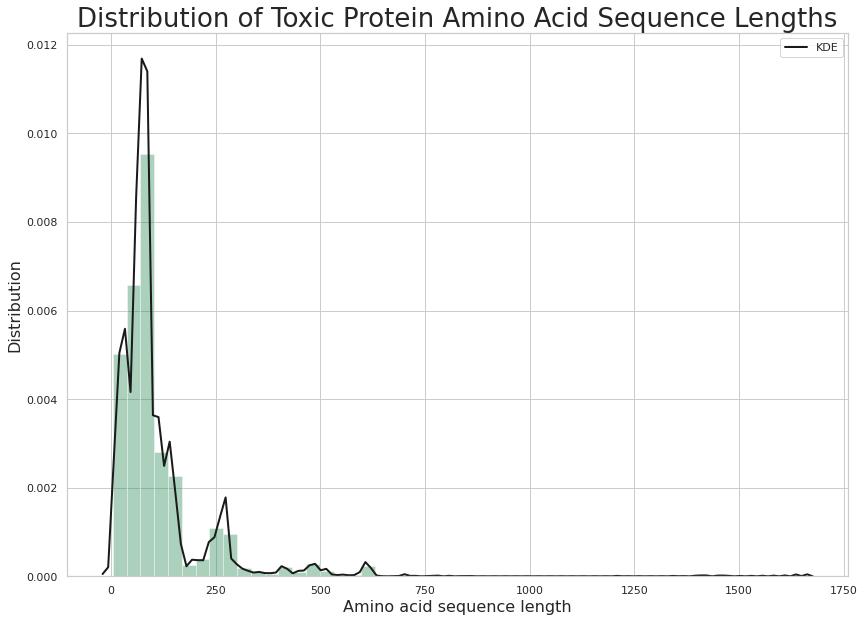

In [16]:
# Toxic distribution
toxic_lengths = [p.length for p in train_toxic_list]
dist_graph(values=toxic_lengths, x_dim=14, y_dim=10,
              title='Distribution of Toxic Protein Amino Acid Sequence Lengths',
              x_label=x_label, y_label=y_label, colour='Seagreen', bins=50)
stats.describe(toxic_lengths)

DescribeResult(nobs=49764, minmax=(4, 34350), mean=358.7904308335343, variance=121788.74053821439, skewness=22.345446995441645, kurtosis=1850.2745106519085)

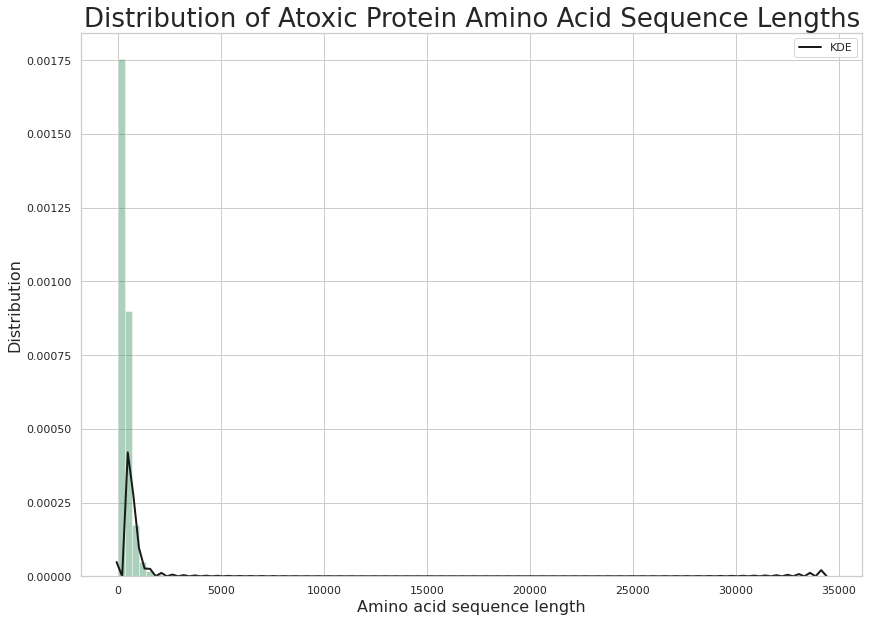

In [17]:
# Atoxic Distribution
atoxic_lengths = [p.length for p in train_atoxic_list]

dist_graph(values=atoxic_lengths, x_dim=14, y_dim=10,
              title='Distribution of Atoxic Protein Amino Acid Sequence Lengths',
              x_label=x_label, y_label=y_label, colour='Seagreen', bins=100)
stats.describe(atoxic_lengths)

# **4. Downsampling training data**

We will need transcribe the values into matrices at some point, but we do not want to kill the RAM, so we set a maximum number of sequence lenght, and use the subset from those

In [18]:
# DOWNSAMPLING PROCESSING FUNCTIONS START
# -----------------------------------------------------------------------------

# VARIABLES
MAX_SEQ_LEN = 500

def crop_sequences(protein_list):
  return [p for p in protein_list if p.length <= MAX_SEQ_LEN]

In [19]:
# Downsampling toxic and atoxic sequences <= MAX_SEQ_LEN
train_toxic_list = crop_sequences(train_toxic_list)
train_atoxic_list = crop_sequences(train_atoxic_list)

total_train_toxic_seqs = len(train_toxic_list)
print('Total training toxic sequences ( <=', MAX_SEQ_LEN, '): ', total_train_toxic_seqs)
print('Total training atoxic sequences ( <=', MAX_SEQ_LEN, '):', len(train_atoxic_list))

Total training toxic sequences ( <= 500 ):  5896
Total training atoxic sequences ( <= 500 ): 40282


In [20]:
# Downsampling testing toxic and atoxic sequences <= MAX_SEQ_LEN
test_toxic_list = crop_sequences(test_toxic_list)
test_atoxic_list = crop_sequences(test_atoxic_list)

total_test_toxic_seqs = len(test_toxic_list)
print('Total testing toxic sequences ( <=', MAX_SEQ_LEN, '): ', total_test_toxic_seqs)
print('Total testing atoxic sequences ( <=', MAX_SEQ_LEN, '):', len(test_atoxic_list))

Total testing toxic sequences ( <= 500 ):  271
Total testing atoxic sequences ( <= 500 ): 62


In [21]:
# Further randomly downsampling training atoxic sequences to equal number of toxic sequences
train_atoxic_list = resample(train_atoxic_list, replace=False, n_samples=total_train_toxic_seqs, random_state=RANDOM_SEED)
print('Total training protein sequences in atoxic list post-downsampling: ', len(train_atoxic_list))

Total training protein sequences in atoxic list post-downsampling:  5896


In [22]:
pickle_method(f_train_proteins_toxic, 'wb', train_toxic_list)
pickle_method(f_train_proteins_atoxic, 'wb', train_atoxic_list)

# **5. Combining Datasets & Appending Values**


In [23]:
# Appending toxic and atoxic 'ProteinSequence' lists
train_proteins = train_toxic_list + train_atoxic_list
print(f'Total training proteins: {len(train_proteins)}')

test_proteins = test_toxic_list + test_atoxic_list
print(f'Total testing proteins:  {len(test_proteins)}')

Total training proteins: 11792
Total testing proteins:  333


In [24]:
# Saving the combined training and testing proteins list to a binary file
pickle_method(f_train_proteins_list, 'wb', train_proteins)
pickle_method(f_test_proteins_list, 'wb', test_proteins)

In [25]:
# -----------------------------------------------
# FUNCTIONS APPENDING ATCHLEY VALUES

# get atchley values - returns list of values
def get_atchley_values_list(letters, idx):
  return [float(dict_atchley.get(i)[idx]) for i in letters]

# matches each atchley value to each amino acid
def get_atchley_values_raw(sequence, seq_dict_r):
  seq_dict_r['f1'] = get_atchley_values_list(sequence, 0)
  seq_dict_r['f2'] = get_atchley_values_list(sequence, 1)
  seq_dict_r['f3'] = get_atchley_values_list(sequence, 2)
  seq_dict_r['f4'] = get_atchley_values_list(sequence, 3)
  seq_dict_r['f5'] = get_atchley_values_list(sequence, 4)

# -----------------------------------------------
# calculates sequential change for single atchley value
def get_change_list(atchley_list):
  atchley_list.insert(0, 0)
  change_list = [i for i in (np.diff(atchley_list))]
  atchley_list.pop(0)
  return change_list

# calculates sequential change for each atchley value
def get_atchley_diff(seq_dict_r, seq_dict_d):
  seq_dict_d['f1_d'] = get_change_list(seq_dict_r.get('f1'))
  seq_dict_d['f2_d'] = get_change_list(seq_dict_r.get('f2'))
  seq_dict_d['f3_d'] = get_change_list(seq_dict_r.get('f3'))
  seq_dict_d['f4_d'] = get_change_list(seq_dict_r.get('f4'))
  seq_dict_d['f5_d'] = get_change_list(seq_dict_r.get('f5'))

# appends the atchley values to the dictionary of a ProteinSequence object
def append_atchley_values(proteins_list):
  for protein in proteins_list:
    get_atchley_values_raw(protein.sequence, protein.seq_dict_raw)
    get_atchley_diff(protein.seq_dict_raw, protein.seq_dict_diff)

In [26]:
# appending atchley values to datasets
append_atchley_values(train_proteins)
append_atchley_values(test_proteins)

**Appending Matrices**

In [27]:
# -----------------------------------------------
# FUNCTIONS UPDATING MATRICES

# returns matrix from input dictionary
def get_matrix_values(seq_dict):
  matrix = np.array([seq_dict[i] for i in seq_dict.keys()])
  return np.pad(matrix, ((0, 0),(0, MAX_SEQ_LEN - len(matrix[0]))), 'constant')

# updates both matrices
def update_matrices(protein_seq_list):
  for protein in protein_seq_list:
    protein.matrix_raw = get_matrix_values(protein.seq_dict_raw)
    protein.matrix_diff = get_matrix_values(protein.seq_dict_diff)

In [28]:
# updating matrices
update_matrices(train_proteins)
update_matrices(test_proteins)

In [29]:
# pickling protein list objects to file for later use
pickle_method(f_train_proteins_list, 'wb', train_proteins)
pickle_method(f_test_proteins_list, 'wb', test_proteins)

In [30]:
# unpickling protein list objects
train_proteins = pickle_method(f_train_proteins_list, 'rb', '')
test_proteins = pickle_method(f_test_proteins_list, 'rb', '')

In [31]:
print('Training proteins shape: ')
print(f'Atchley values raw maginitude:    {train_proteins[0].matrix_raw.shape}')
print(f'Atchley values sequential change: {train_proteins[0].matrix_diff.shape}')

print('\nTesting proteins shape:')
print(f'Atchley values raw maginitude:    {test_proteins[0].matrix_raw.shape}')
print(f'Atchley values sequential change: {test_proteins[0].matrix_diff.shape}')

Training proteins shape: 
Atchley values raw maginitude:    (5, 500)
Atchley values sequential change: (5, 500)

Testing proteins shape:
Atchley values raw maginitude:    (5, 500)
Atchley values sequential change: (5, 500)


In [32]:
# adding training and testing proteins list to dataframes
df_train_combined = pd.DataFrame.from_records([p.to_dict_combined() for p in train_proteins])
df_test_combined = pd.DataFrame.from_records([p.to_dict_combined() for p in test_proteins])

# pickling dataframe files 
pickle_method(f_train_atchley_combined, 'wb', df_train_combined)
pickle_method(f_test_atchley_combined, 'wb', df_test_combined)

In [33]:
# unpickling dataframe files 
df_train_combined = pickle_method(f_train_atchley_combined, 'rb', '')
df_test_combined = pickle_method(f_test_atchley_combined, 'rb', '')

In [34]:
# Looking at what the training data is like
df_train_combined.head(5)

,identifier,toxic,length,sequence,matrix_raw,matrix_diff,f1_raw,f2_raw,f3_raw,f4_raw,f5_raw,atchley_raw_avg,f1_diff,f2_diff,f3_diff,f4_diff,f5_diff,atchley_diff_avg
0,sp|C0HJT4|3NOJ_DENAN,1,63,"[L, E, C, H, R, R, G, S, F, I, S, D, G, K, I, ...","[[-1.019, 1.357, -1.343, 0.336, 1.538, 1.538, ...","[[-1.019, 2.376, -2.7, 1.679, 1.202, 0.0, -1.9...","[-1.019, 1.357, -1.343, 0.336, 1.538, 1.538, -...","[-0.987, -1.453, 0.465, -0.417, -0.055, -0.055...","[-1.505, 1.477, -0.862, -1.673, 1.502, 1.502, ...","[1.266, 0.113, -1.02, -1.474, 0.44, 0.44, 1.04...","[-0.912, -0.837, -0.255, -0.078, 2.897, 2.897,...","[-0.6314, 0.13140000000000002, -0.603, -0.6611...","[-1.019, 2.376, -2.7, 1.679, 1.202, 0.0, -1.92...","[-0.987, -0.4660000000000001, 1.91800000000000...","[-1.505, 2.982, -2.339, -0.811, 3.175, 0.0, -0...","[1.266, -1.153, -1.133, -0.45399999999999996, ...","[-0.912, 0.07500000000000007, 0.582, 0.177, 2....","[-0.6314, 0.7627999999999999, -0.7343999999999..."
1,sp|C0HJR6|VSP2_CRODO,1,29,"[T, A, L, P, Q, L, R, L, P, A, T, S, R, I, L, ...","[[-0.032, -0.591, -1.019, 0.189, 0.931, -1.019...","[[-0.032, -0.5589999999999999, -0.427999999999...","[-0.032, -0.591, -1.019, 0.189, 0.931, -1.019,...","[0.326, -1.302, -0.987, 2.081, -0.179, -0.987,...","[2.213, -0.733, -1.505, -1.628, -3.005, -1.505...","[0.908, 1.57, 1.266, 0.421, -0.503, 1.266, 0.4...","[1.313, -0.146, -0.912, -1.392, -1.853, -0.912...","[0.9456, -0.24039999999999995, -0.6314, -0.065...","[-0.032, -0.5589999999999999, -0.4279999999999...","[0.326, -1.6280000000000001, 0.315000000000000...","[2.213, -2.946, -0.7719999999999999, -0.123, -...","[0.908, 0.662, -0.30400000000000005, -0.845, -...","[1.313, -1.4589999999999999, -0.766, -0.479999...","[0.9456, -1.1860000000000002, -0.3909999999999..."
2,sp|A0A0S4FKT4|VSP1_CRODO,1,238,"[V, I, G, G, D, E, C, N, I, N, E, H, N, F, L, ...","[[-1.337, -1.239, -0.384, -0.384, 1.05, 1.357,...","[[-1.337, 0.09799999999999986, 0.8550000000000...","[-1.337, -1.239, -0.384, -0.384, 1.05, 1.357, ...","[-0.279, -0.547, 1.652, 1.652, 0.302, -1.453, ...","[-0.544, 2.131, 1.33, 1.33, -3.656, 1.477, -0....","[1.242, 0.393, 1.045, 1.045, -0.259, 0.113, -1...","[-1.262, 0.816, 2.064, 2.064, -3.242, -0.837, ...","[-0.43600000000000005, 0.31079999999999997, 1....","[-1.337, 0.09799999999999986, 0.85500000000000...","[-0.279, -0.268, 2.199, 0.0, -1.34999999999999...","[-0.544, 2.675, -0.8009999999999997, 0.0, -4.9...","[1.242, -0.849, 0.6519999999999999, 0.0, -1.30...","[-1.262, 2.078, 1.2480000000000002, 0.0, -5.30...","[-0.43600000000000005, 0.7468, 0.8306000000000..."
3,sp|C0HK05|PA2BC_CROOL,1,47,"[H, L, L, Q, F, N, K, M, I, K, F, E, T, R, K, ...","[[0.336, -1.019, -1.019, 0.931, -1.006, 0.945,...","[[0.336, -1.355, 0.0, 1.95, -1.937, 1.951, 0.8...","[0.336, -1.019, -1.019, 0.931, -1.006, 0.945, ...","[-0.417, -0.987, -0.987, -0.179, -0.59, 0.828,...","[-1.673, -1.505, -1.505, -3.005, 1.891, 1.299,...","[-1.474, 1.266, 1.266, -0.503, -0.397, -0.169,...","[-0.078, -0.912, -0.912, -1.853, 0.412, 0.933,...","[-0.6611999999999999, -0.6314, -0.6314, -0.921...","[0.336, -1.355, 0.0, 1.95, -1.937, 1.951, 0.88...","[-0.417, -0.5700000000000001, 0.0, 0.808, -0.4...","[-1.673, 0.16800000000000015, 0.0, -1.5, 4.896...","[-1.474, 2.74, 0.0, -1.7690000000000001, 0.105...","[-0.078, -0.8340000000000001, 0.0, -0.941, 2.2...","[-0.6611999999999999, 0.02980000000000005, 0.0..."
4,sp|P0DL64|HPR3_THRPR,1,33,"[D, C, L, K, F, G, W, K, C, N, P, R, N, D, K, ...","[[1.05, -1.343, -1.019, 1.831, -1.006, -0.384,...","[[1.05, -2.393, 0.32400000000000007, 2.8499999...","[1.05, -1.343, -1.019, 1.831, -1.006, -0.384, ...","[0.302, 0.465, -0.987, -0.561, -0.59, 1.652, 0...","[-3.656, -0.862, -1.505, 0.533, 1.891, 1.33, 0...","[-0.259, -1.02, 1.266, -0.277, -0.397, 1.045, ...","[-3.242, -0.255, -0.912, 1.648, 0.412, 2.064, ...","[-1.161, -0.603, -0.6314, 0.6347999999999999, ...","[1.05, -2.393, 0.32400000000000007, 2.84999999...","[0.302, 0.16300000000000003, -1.452, 0.4259999..

In [35]:
# Checking what type of object the matrix we created are
print((type(df_train_combined['atchley_diff_avg'][0])))
print((type(df_train_combined['matrix_raw'][0])))
print((type(df_train_combined['matrix_diff'][0])))

print((type(df_test_combined['atchley_diff_avg'][0])))
print((type(df_test_combined['matrix_raw'][0])))
print((type(df_test_combined['matrix_diff'][0])))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [36]:
# Training DataFrame information
print('\nCombined training set info:\n')
df_train_combined.info()


Combined training set info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   identifier        11792 non-null  object
 1   toxic             11792 non-null  int64 
 2   length            11792 non-null  int64 
 3   sequence          11792 non-null  object
 4   matrix_raw        11792 non-null  object
 5   matrix_diff       11792 non-null  object
 6   f1_raw            11792 non-null  object
 7   f2_raw            11792 non-null  object
 8   f3_raw            11792 non-null  object
 9   f4_raw            11792 non-null  object
 10  f5_raw            11792 non-null  object
 11  atchley_raw_avg   11792 non-null  object
 12  f1_diff           11792 non-null  object
 13  f2_diff           11792 non-null  object
 14  f3_diff           11792 non-null  object
 15  f4_diff           11792 non-null  object
 16  f5_diff           11792 non-

In [37]:
# Testing DataFrame information
print('\nCombined testing set info:\n')
df_test_combined.info()


Combined testing set info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   identifier        333 non-null    object
 1   toxic             333 non-null    int64 
 2   length            333 non-null    int64 
 3   sequence          333 non-null    object
 4   matrix_raw        333 non-null    object
 5   matrix_diff       333 non-null    object
 6   f1_raw            333 non-null    object
 7   f2_raw            333 non-null    object
 8   f3_raw            333 non-null    object
 9   f4_raw            333 non-null    object
 10  f5_raw            333 non-null    object
 11  atchley_raw_avg   333 non-null    object
 12  f1_diff           333 non-null    object
 13  f2_diff           333 non-null    object
 14  f3_diff           333 non-null    object
 15  f4_diff           333 non-null    object
 16  f5_diff           333 non-null   

In [38]:
# Checking if classes for training data are balanced between toxic and atoxic
print('\nChecking value counts for each class in df combined:\n1 == toxic\n0 == atoxic\n----------')
print(df_train_combined['toxic'].value_counts())


Checking value counts for each class in df combined:
1 == toxic
0 == atoxic
----------
1    5896
0    5896
Name: toxic, dtype: int64




---

